# Signal vs. Noise – Simulation Demo

In this notebook, we simulate a signal+noise dataset and demonstrate how noise affects our ability to detect a true effect using a General Linear Model (GLM). We then apply a simple denoising method and re-fit the GLM.

## 1. Simulate signal + noise

In [208]:
noise_type = "spike" # can be spike or white

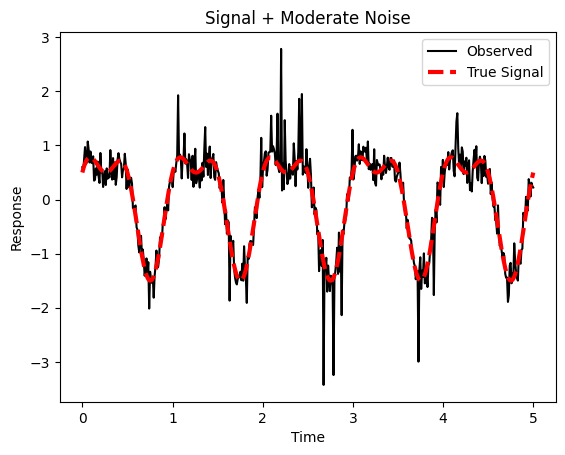

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display

np.random.seed(42)

# Parameters
n = 500
beta = 1                          # true effect size

# Generate a sinusoidal signal
t = np.linspace(0, 5, n)
X = np.sin(2*np.pi*t) + 0.5*np.sin(2*np.pi*2*t + 1.5)
signal = X * beta                   # Sinusoidal function with amplitude beta

if noise_type == "white":
    # Generate white noise
    noise = np.random.normal(0, 1, n)
elif noise_type == "spike":
    # Generate spike noise (outliers that mess up GLM)
    noise = np.random.normal(0, 0.2, n)  # Small background noise
    # Add random spikes (outliers) that bias the effect size
    spike_probability = 0.05
    spike_locations = np.random.random(n) < spike_probability
    # Create systematic bias: spikes are more likely to be positive when X is positive
    # This creates apparent correlation and inflates the effect size
    spike_magnitudes = np.random.normal(0, 0.5, n)  # Large spikes
    # Bias spikes based on X values to affect slope
    bias_factor = 1.0  # Strength of bias
    spike_magnitudes[spike_locations] += bias_factor * X[spike_locations]
    noise[spike_locations] += spike_magnitudes[spike_locations]

# Add noise
Y = signal + noise

# Visualize
plt.plot(t, Y, color='k', label='Observed')
plt.plot(t, signal, color='r', label='True Signal', linestyle='--', linewidth=3)
plt.xlabel('Time'); plt.ylabel('Response')
plt.legend(); plt.title('Signal + Moderate Noise')
plt.show()

## 2. Fit GLM to detect signal

In [210]:

X_design = sm.add_constant(X)
model = sm.OLS(Y, X_design).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     3563.
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          4.33e-229
Time:                        15:43:01   Log-Likelihood:                -123.28
No. Observations:                 500   AIC:                             250.6
Df Residuals:                     498   BIC:                             259.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.014      0.348      0.7

## 3. Visualize the fit

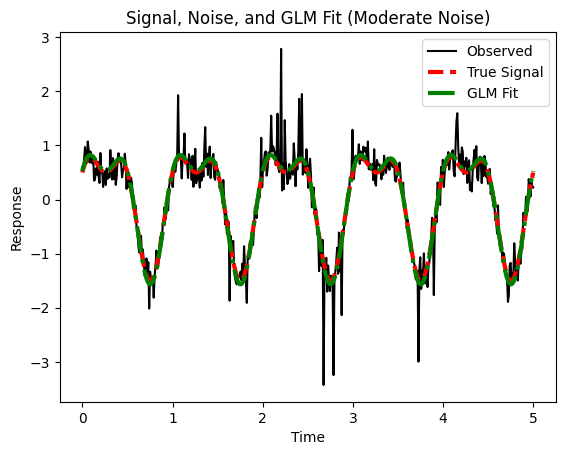

In [211]:
# Visualize the fitted model
plt.plot(t, Y, color='k', label='Observed')
plt.plot(t, signal, color='r', label='True Signal', linestyle='--', linewidth=3)
plt.plot(t, model.predict(X_design), label='GLM Fit', linestyle='-.', linewidth=3, color='g')
plt.xlabel('Time'); plt.ylabel('Response')
plt.legend(); plt.title('Signal, Noise, and GLM Fit (Moderate Noise)')
plt.show()

## 4. Add stronger noise – effect becomes hard to detect

In [212]:
output = widgets.Output()
stored_result = {}

def show_noisy_model(std=1.0):
    with output:
        output.clear_output(wait=True)

        if noise_type == "white":
            # Generate white noise
            noise = np.random.normal(0, std, n)
        elif noise_type == "spike":
            # Generate spike noise (outliers that mess up GLM)
            noise = np.random.normal(0, 0.2, n)  # Small background noise
            # Add random spikes (outliers) that bias the effect size
            spike_probability = 0.05
            spike_locations = np.random.random(n) < spike_probability
            # Create systematic bias: spikes are more likely to be positive when X is positive
            # This creates apparent correlation and inflates the effect size
            spike_magnitudes = np.random.normal(0, 0.5, n)  # Large spikes
            # Bias spikes based on X values to affect slope
            bias_factor = -std  # Strength of bias
            spike_magnitudes[spike_locations] += bias_factor * X[spike_locations]
            noise[spike_locations] += spike_magnitudes[spike_locations]

        Y_noisy = signal + noise
        stored_result["Y_noisy"] = Y_noisy

        # Fit model
        model = sm.OLS(Y_noisy, X_design).fit()

        # Plot
        plt.plot(t, Y_noisy, color='k', label='Observed')
        plt.plot(t, signal, color='r', label='True Signal', linestyle='--', linewidth=3)
        plt.plot(t, model.predict(X_design), label='GLM Fit', linestyle='-.', linewidth=3, color='g')
        plt.xlabel('Time'); plt.ylabel('Response')
        plt.legend(); plt.title('Signal, Noise, and GLM Fit (Interactive)')
        plt.show()

        print(model.summary())

interact(show_noisy_model, std=FloatSlider(min=0.1, max=20.0, step=0.5, value=1.0, description='Noise'))
display(output)

interactive(children=(FloatSlider(value=1.0, description='Noise', max=20.0, min=0.1, step=0.5), Output()), _do…

Output()

## 5. Denoising

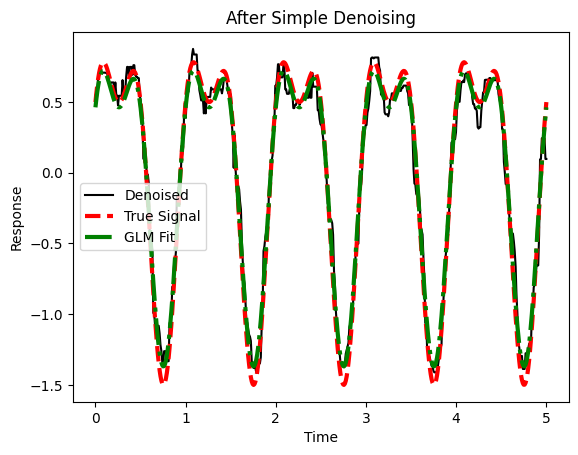

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.722e+04
Date:                Wed, 09 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:43:44   Log-Likelihood:                 452.41
No. Observations:                 500   AIC:                            -900.8
Df Residuals:                     498   BIC:                            -892.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.082      0.2

In [215]:
# Retrieve Y_noisy from stored_result
Y_noisy = stored_result["Y_noisy"]  # retrieve from stored result


if noise_type == "white":
    # Apply Gaussian filter
    sigma = 5  # standard deviation in samples
    Y_denoised = gaussian_filter1d(Y_noisy, sigma=sigma)
elif noise_type == "spike":
    # Denoising using median filter
    # Perfect for spike noise - replaces outliers with median of neighbors
    window_size = 11  # Size of median filter window
    Y_denoised = medfilt(Y_noisy, kernel_size=window_size)

# Re-fit GLM
model_denoised = sm.OLS(Y_denoised, X_design).fit()

# Plot
plt.plot(t, Y_denoised, color='k', label='Denoised')
plt.plot(t, signal, color='r', label='True Signal', linestyle='--', linewidth=3)
plt.plot(t, model_denoised.predict(X_design), label='GLM Fit', linestyle='-.', linewidth=3, color='g')
plt.xlabel('Time'); plt.ylabel('Response')
plt.legend(); plt.title('After Simple Denoising')
plt.show()

plt.show()

print(model_denoised.summary())
